In [1]:
from data_sim_module import get_curve_samples, multi_partite_distance, get_questionnaires, \
                            get_true_mds, compute_mds, align_pca_mds, corr_between_coords
import pandas as pd
import numpy as np
import scipy.stats
import pickle

from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import TSNE

# plotting
import matplotlib.pyplot as plt
plt.rcParams.update({"font.size" : 15, 
                     "figure.dpi" : 100, 
                     "legend.fontsize" : 13, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": True, 
                     "axes.axisbelow" : True, 
                     "figure.figsize":(6, 5)})

In [2]:
number_q = 8
number_a = 3
N = number_a**number_q

kappa = [1, 2, N-1, 1, 2, N-1]
m = 3

num_samples   = [20, 20, 20, 50, 50, 50]
num_responses = [25, 25, 25, 50, 50, 50]

# Generate 30 questionnaires per param combination

In [141]:
questionnaires = {}

for k in [1, 2, N-1]:
    for n in [20, 50]:
        
        key = (k, n)
        print(key)
        
        if key not in questionnaires:
            questionnaires[key] = {"questionnaires":[]}
        
        # PDFs
        probs = get_curve_samples(number_q=8, number_a=3, samples=n, m=3, sin_angle=k-1)
        questionnaires[key]["probs"] = probs
        
        # MI distances
        MI = multi_partite_distance(probs)
        questionnaires[key]["MI"] = MI
        
        # theoretical embedding
        true_mds = get_true_mds(probs)
        questionnaires[key]["theoretical_embedding"] = true_mds
        
        # generate sample questionnaires
        for rep in range(30):
            if n == 20:
                df = get_questionnaires(probs, count_answers=25, number_q=8, number_a=3)
            else:
                df = get_questionnaires(probs, count_answers=50, number_q=8, number_a=3)
            questionnaires[key]["questionnaires"].append(df)
            
with open("questionnaires.pickle", "wb") as f:
    pickle.dump(questionnaires, f)

(1, 20)
(1, 50)
(2, 20)
(2, 50)
(6560, 20)
(6560, 50)


In [3]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

# Results

In [4]:
RESULTS = {}
with open(f"tsne_results.pickle", "rb") as f:
    RESULTS["tsne"] = pickle.load(f)
with open(f"fine_results.pickle", "rb") as f:
    RESULTS["fine"] = pickle.load(f)
with open(f"dm_results.pickle", "rb") as f:
    RESULTS["dm"] = pickle.load(f)

In [20]:
# FINE
fine_means = []
fine_intervals = []
fine_corrs = {}
for key, df_dict in RESULTS["fine"].items():
    fine_corrs[key] = []
    for df_idx, df_results in df_dict.items():
        fine_corrs[key].append(df_results["none"]["corr"])
    conf_int = mean_confidence_interval(fine_corrs[key])
    fine_means.append(round(conf_int[0],3))
    fine_intervals.append(round(conf_int[1],3))

In [21]:
# TSNE
tsne_means = []
tsne_intervals = []
tsne_corrs = {}

for key, df_dict in RESULTS["tsne"].items():
    print(key)
    tsne_corrs[key] = []
    corrs = {}
    for df_idx, df_results in df_dict.items():
        for param_combination in df_results:
            if param_combination not in corrs:
                corrs[param_combination] = []
            corrs[param_combination].append(df_results[param_combination]["corr"])
    
    conf_intervals = []
    for param_combination, vals in corrs.items():
        conf_int = mean_confidence_interval(vals)
        conf_intervals.append((param_combination, round(conf_int[0],3), round(conf_int[1],3))) 
    conf_intervals = sorted(conf_intervals, key=lambda x: x[1], reverse=True)[0]
    tsne_means.append(conf_intervals[1])
    tsne_intervals.append(conf_intervals[2])
    tsne_corrs[key] = corrs[conf_intervals[0]]
    print(conf_intervals)
    print()

(1, 20)
(('hamming', 2, 50), 0.891, 0.018)

(1, 50)
(('hamming', 5, 200), 0.921, 0.007)

(2, 20)
(('hamming 1hot', 2, 50), 0.879, 0.02)

(2, 50)
(('hamming 1hot', 10, 200), 0.927, 0.009)

(6560, 20)
(('hamming 1hot', 2, 50), 0.913, 0.009)

(6560, 50)
(('hamming 1hot', 1, 50), 0.937, 0.004)



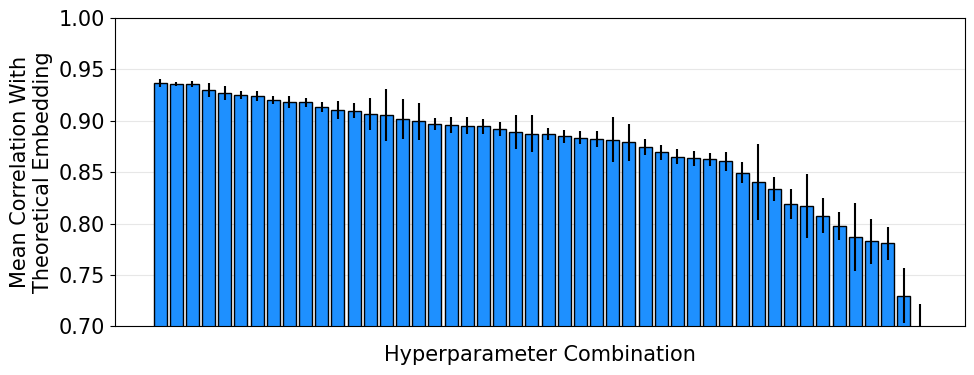

In [88]:
labels = list(corrs.keys())
x = np.arange(len(labels))

param_conf_ints = sorted([(mean_confidence_interval(corrs[k]),k) for k in labels], 
                         key = lambda x:x[0][0], reverse=True)

param_means = [x[0][0] for x in param_conf_ints]
param_intervals = [x[0][1] for x in param_conf_ints]

fig, ax = plt.subplots(figsize=(10,4))

bars = ax.bar(x , param_means, yerr=param_intervals, 
              label='FINE', color="dodgerblue", edgecolor="k")

ax.set_xlabel("Hyperparameter Combination", labelpad=10)
ax.set_ylabel('Mean Correlation With\nTheoretical Embedding')
ax.set_title("")
ax.set_xticks([])
# ax.set_xticks(x, labels, rotation=90)

ax.set_ylim(0.7, 1)

fig.tight_layout()

plt.show()

In [22]:
# DM
dm_means = []
dm_intervals = []
dm_corrs = {}

for key, df_dict in RESULTS["dm"].items():
    print(key)
    dm_corrs[key] = []
    corrs = {}
    for df_idx, df_results in df_dict.items():
        for param_combination in df_results:
            if param_combination not in corrs:
                corrs[param_combination] = []
            corrs[param_combination].append(df_results[param_combination]["corr"])
    
    conf_intervals = []
    for param_combination, vals in corrs.items():
        conf_int = mean_confidence_interval(vals)
        conf_intervals.append((param_combination, round(conf_int[0],3), round(conf_int[1],3))) 
    conf_intervals = sorted(conf_intervals, key=lambda x: x[1], reverse=True)[0]
    dm_means.append(conf_intervals[1])
    dm_intervals.append(conf_intervals[2])
    dm_corrs[key] = corrs[conf_intervals[0]]
    print(conf_intervals)
    print()

(1, 20)
(('cosine 1hot', 1.5, 0.5), 0.91, 0.008)

(1, 50)
(('cosine 1hot', 1.5, 0.5), 0.932, 0.002)

(2, 20)
(('cosine 1hot', 0.5, 0.5), 0.9, 0.009)

(2, 50)
(('cosine 1hot', 0.5, 0.5), 0.93, 0.002)

(6560, 20)
(('cosine 1hot', 2, 0.5), 0.924, 0.008)

(6560, 50)
(('cosine 1hot', 2, 0), 0.945, 0.002)



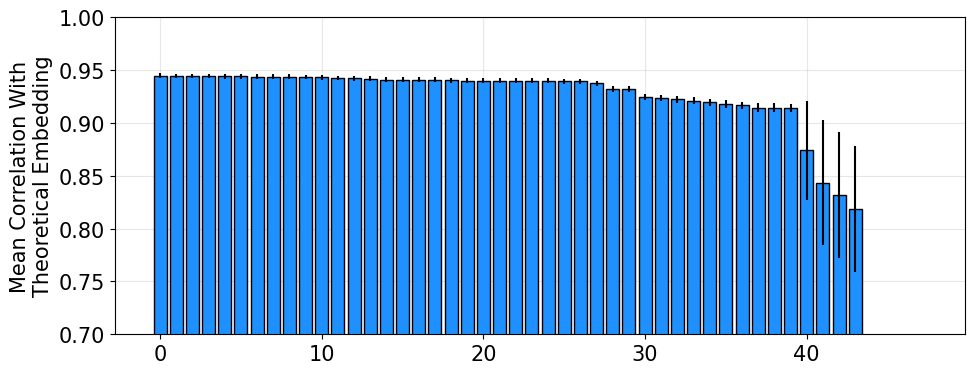

In [91]:
labels = list(corrs.keys())
x = np.arange(len(labels))

param_conf_ints = sorted([(mean_confidence_interval(corrs[k]),k) for k in labels], 
                         key = lambda x:x[0][0], reverse=True)

param_means = [x[0][0] for x in param_conf_ints]
param_intervals = [x[0][1] for x in param_conf_ints]

fig, ax = plt.subplots(figsize=(10,4))

bars = ax.bar(x , param_means, yerr=param_intervals, color="dodgerblue", edgecolor="k")

ax.set_ylabel('Mean Correlation With\nTheoretical Embedding')
ax.set_title("")
# ax.set_xticks(x, labels, rotation=90)
ax.set_ylim(0.7, 1)

fig.tight_layout()

plt.show()

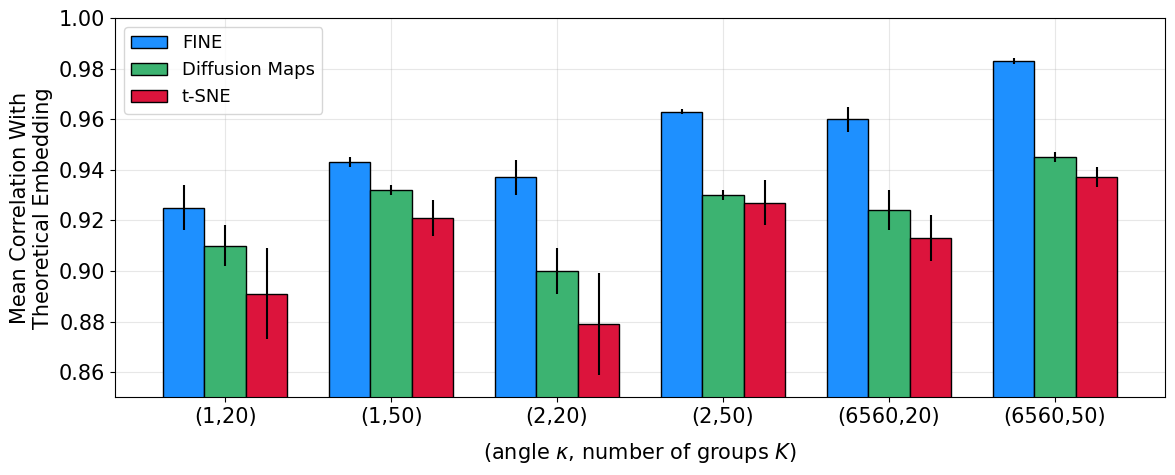

In [92]:
labels = ['(1,20)', '(1,50)', '(2,20)', '(2,50)', '(6560,20)', '(6560,50)']
x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(12,5))

rects1 = ax.bar(x - width, fine_means, width, yerr=fine_intervals, 
                label='FINE', color="dodgerblue", edgecolor="k")

rects3 = ax.bar(x, dm_means, width, yerr=dm_intervals,
                label='Diffusion Maps', color="mediumseagreen", edgecolor="k")

rects2 = ax.bar(x + width, tsne_means, width, yerr=tsne_intervals,
                label='t-SNE', color="crimson", edgecolor="k")

ax.set_xlabel(r"(angle $\kappa$, number of groups $K$)", labelpad=10)
ax.set_ylabel('Mean Correlation With\nTheoretical Embedding')
ax.set_xticks(x, labels)
ax.legend(loc="upper left")

ax.set_ylim(0.85,1)

fig.tight_layout()

# plt.savefig("sim_framework_results.pdf", bbox_inches="tight")

plt.show()

In [33]:
ordered_keys = [(1,20), (2,20), (6560, 20), (1,50), (2,50), (6560,50)]

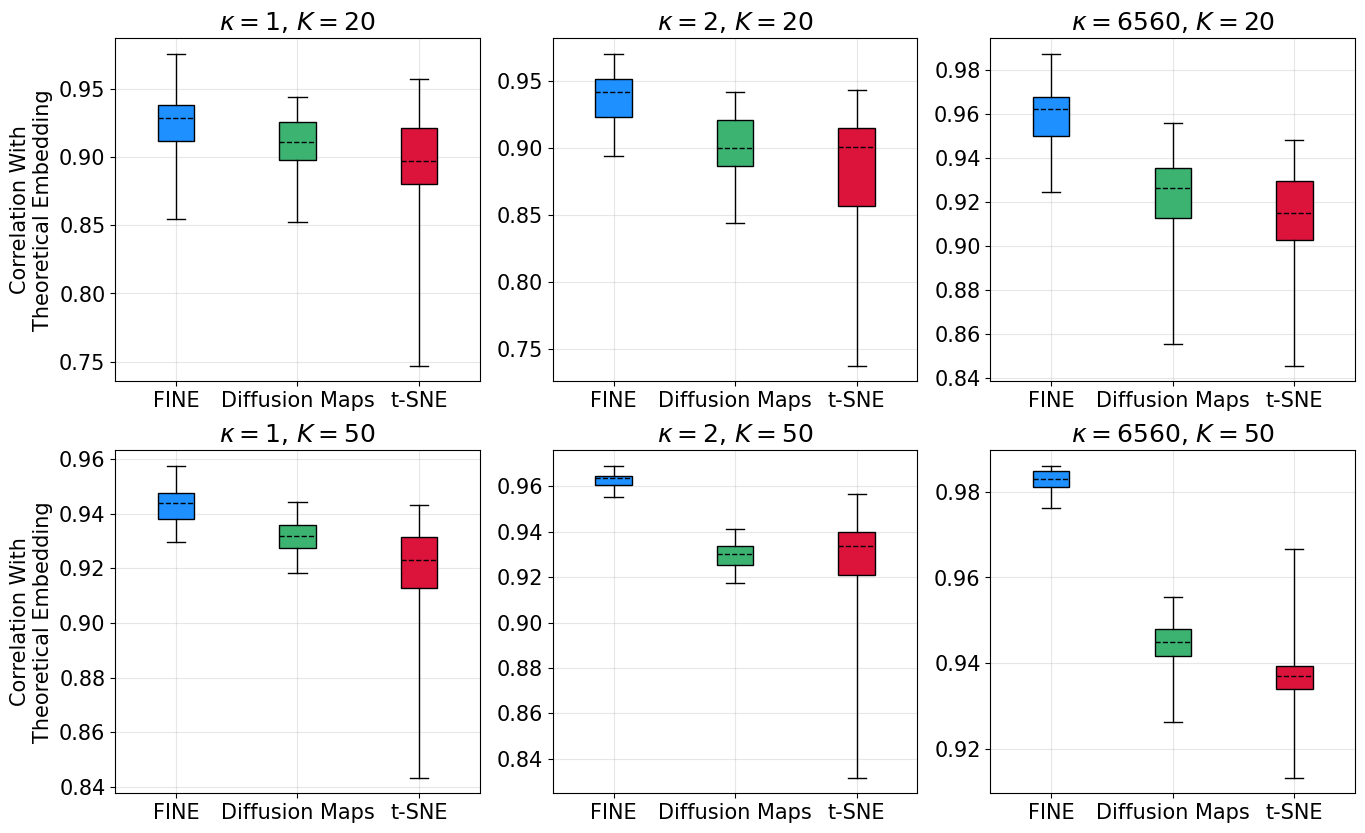

In [39]:
plt.figure(figsize=(16,10))

for i, key in enumerate(ordered_keys):
    plt.subplot(2, 3, i+1)
    bp = plt.boxplot([fine_corrs[key], dm_corrs[key], tsne_corrs[key]], 
                     whis=(0,100), patch_artist=True, 
                     medianprops=dict(color="black", linewidth=1, linestyle="dashed"))
    colors = ['dodgerblue', 'mediumseagreen', 'crimson']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    if i in [0, 3]:
        plt.ylabel("Correlation With\nTheoretical Embedding")
    
    plt.xticks(np.arange(1,4), ["FINE", "Diffusion Maps", "t-SNE"])
    plt.title(r"$\kappa = $" + f"{key[0]}, " + r"$K = $" + f"{key[1]}")

plt.savefig("sim_framework_results.pdf", bbox_inches="tight")
plt.show()

# MI and Embedding Comparison

In [21]:
with open("questionnaires.pickle", "rb") as f:
    data = pickle.load(f)
    
with open("../../../MI.pickle", "rb") as f:
    MI_data = pickle.load(f)

In [22]:
best_params = {
    (1,20):{"tsne":("hamming", 2, 50),
            "dm":("cosine 1hot", 1.5, 0.5)},
    
    (2,20):{"tsne":("hamming 1hot", 1, 50),
            "dm":("cosine 1hot", 1.5, 0.5)},
    
    (6560,20):{"tsne":("hamming 1hot", 1, 50),
               "dm":("cosine 1hot", 0.5, 0.5)},
    
    (1,50):{"tsne":("hamming", 1, 50),
            "dm":("cosine 1hot", 1.5, 0.5)},
    
    (2,50):{"tsne":("hamming 1hot", 1, 50),
            "dm":("cosine 1hot", 0.5, 0.5)},
    
    (6560,50):{"tsne":("hamming 1hot", 1, 50),
               "dm":("cosine 1hot", 1, 0.5)}
}

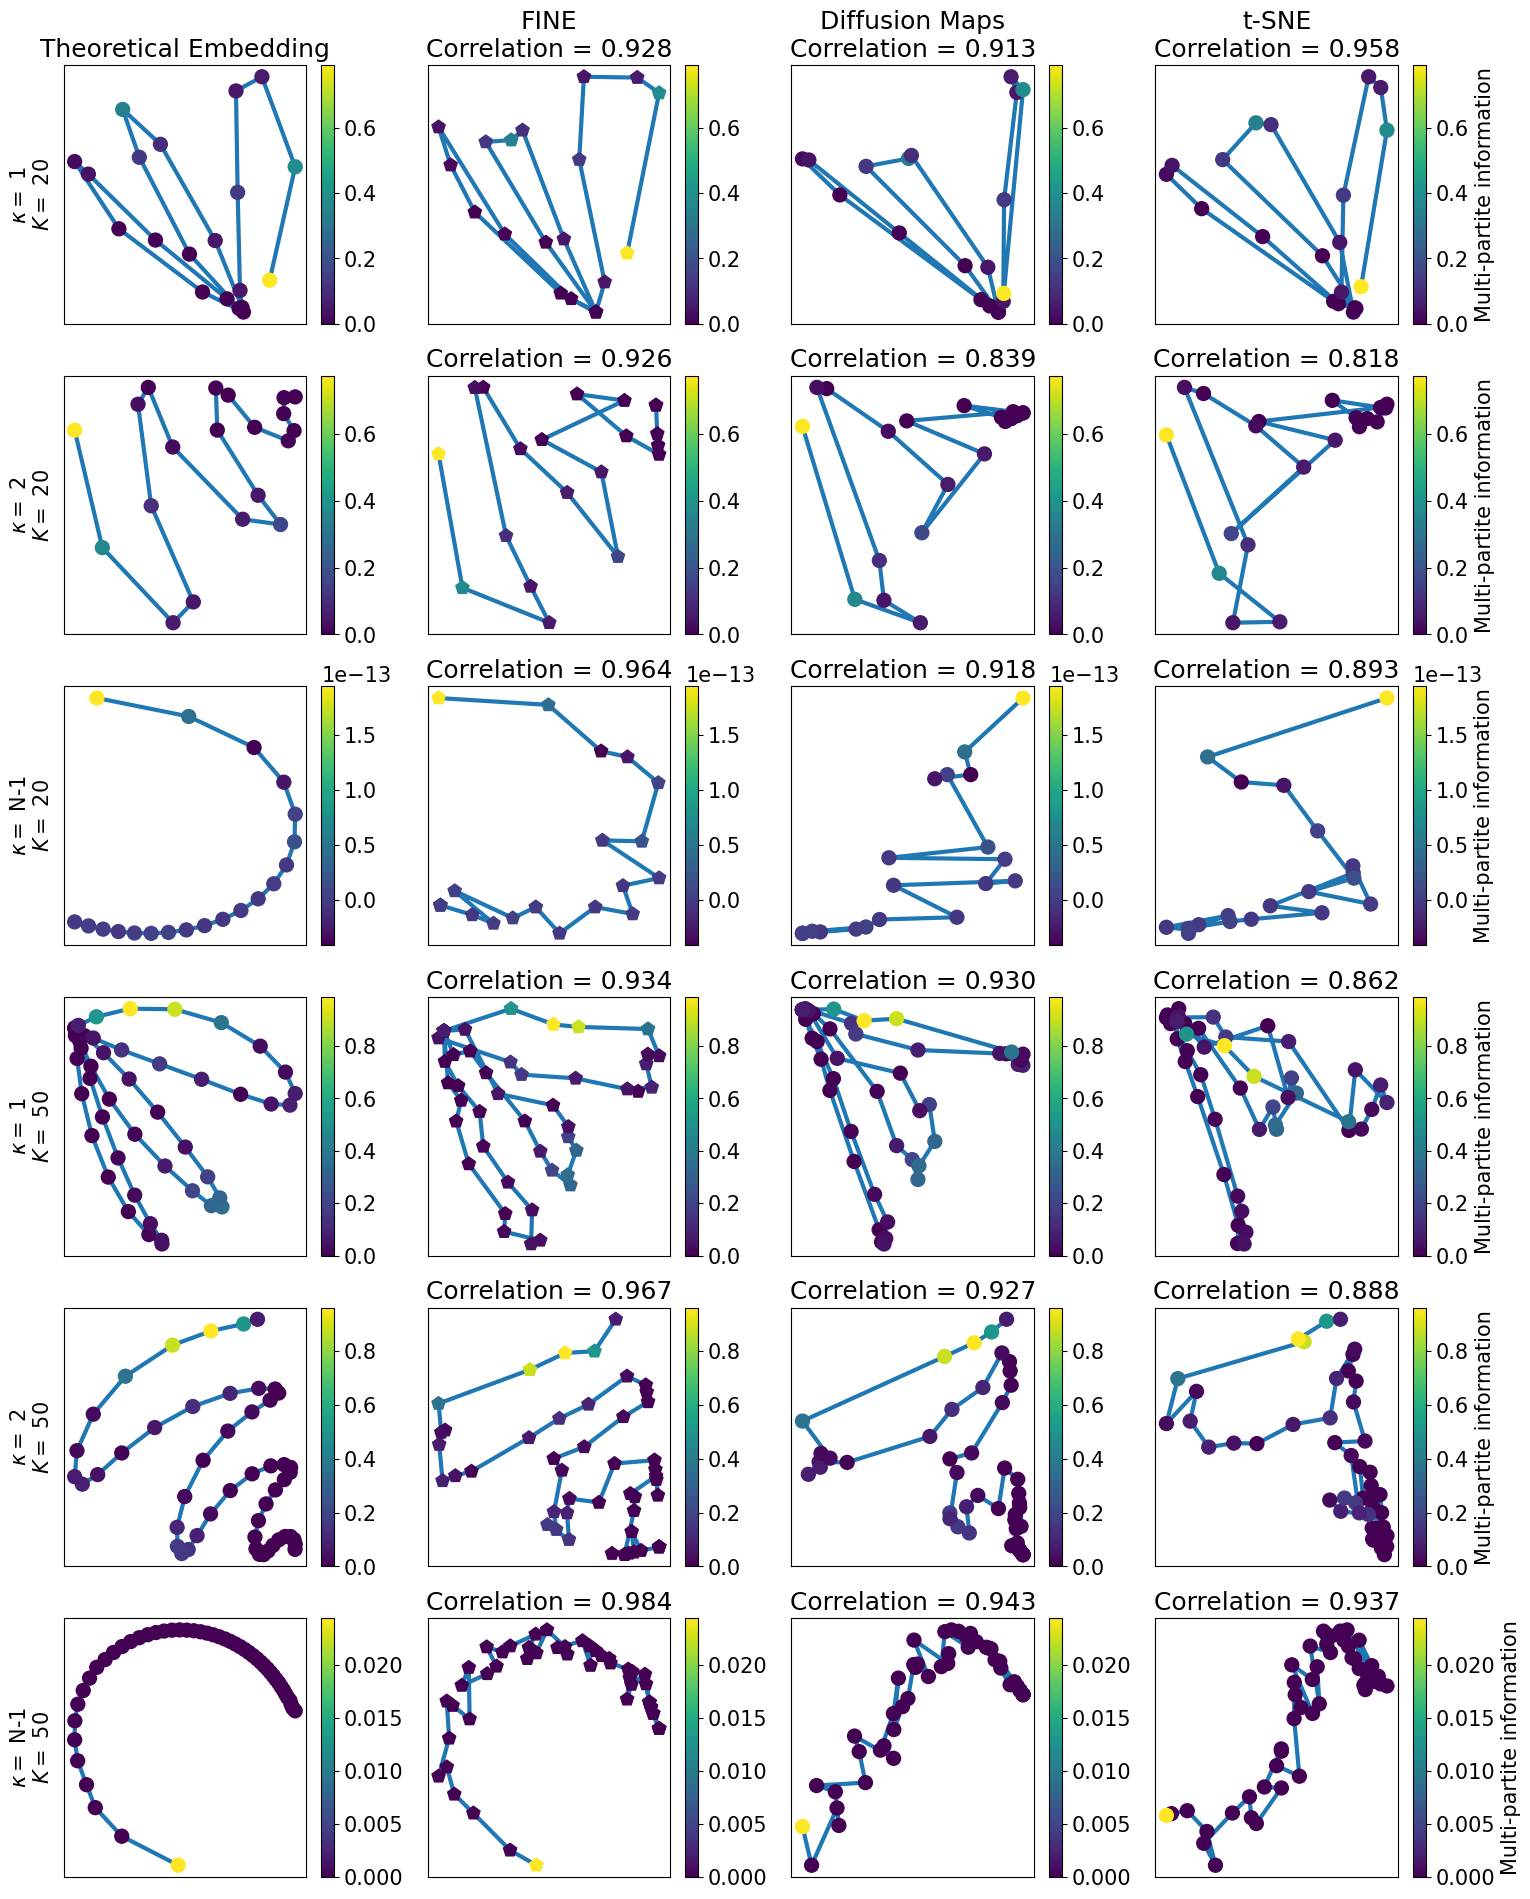

In [23]:
plt.figure(figsize=(18,24))

df_idx = 0

for i, key in enumerate(best_params.keys()):

    KLs = MI_data[key]
    
    # theoretical embedding
    true_mds = data[key]["theoretical_embedding"]
    plt.subplot(6, 4, 4*i+1)
    plt.scatter(true_mds[:,0], true_mds[:,1], marker='o', label="True FI", c=KLs, s=100, zorder=3)
    plt.plot(true_mds[:,0], true_mds[:,1], label="True FI", lw=3, zorder=2)
    if i == 0:
        plt.title("Theoretical Embedding")
    plt.xticks([])
    plt.yticks([])
    if i in [0, 3]:
        kappa = "1"
    elif i in [1, 4]:
        kappa = "2"
    else:
        kappa = "N-1"
    if i < 3:
        K = "20"
    else:
        K = "50"
    plt.ylabel(r"$\kappa = $ " + kappa + "\n" + r"$K = $ " + K)
    cb = plt.colorbar()
    cb.ax.yaxis.set_offset_position('left')
    cb.update_ticks()
    
    
    # Fisher information
    mds_joint = RESULTS["fine"][key][df_idx]["none"]["coords"]
    fi_corr = RESULTS["fine"][key][df_idx]["none"]["corr"]
    plt.subplot(6, 4, 4*i+2)
    plt.scatter(mds_joint[:,0], mds_joint[:,1], marker='p', label="FI Joint", c=KLs, s=100, zorder=3)
    plt.plot(mds_joint[:,0], mds_joint[:,1],  label="FI Joint", lw=3, zorder=2)
    if i == 0:
        plt.title("FINE\nCorrelation = %.3f" % fi_corr)
    else:
         plt.title("\nCorrelation = %.3f" % fi_corr)
    plt.xticks([])
    plt.yticks([])
    cb = plt.colorbar()
    cb.ax.yaxis.set_offset_position('left')
    cb.update_ticks()
    
    
    # Diffusion maps
    dm = RESULTS["dm"][key][df_idx][best_params[key]["dm"]]["coords"]
    dm_corr = RESULTS["dm"][key][df_idx][best_params[key]["dm"]]["corr"]
    
    plt.subplot(6, 4, 4*i+3)
    plt.scatter(dm[:,0], dm[:,1], label="Diffusion Maps", c=KLs, s=100, zorder=3)
    plt.plot(dm[:,0], dm[:,1], lw=3, zorder=2)
    if i == 0:
        plt.title("Diffusion Maps\nCorrelation = %.3f" % dm_corr)
    else:
        plt.title("\nCorrelation = %.3f" % dm_corr)
    plt.xticks([])
    plt.yticks([])
    cb = plt.colorbar()
    cb.ax.yaxis.set_offset_position('left')
    cb.update_ticks()
    

    # T-SNE
    plt.subplot(6, 4, 4*i+4)
    tsne = RESULTS["tsne"][key][df_idx][best_params[key]["tsne"]]["coords"]
    tsne_corr = RESULTS["tsne"][key][df_idx][best_params[key]["tsne"]]["corr"]
    
    plt.scatter(tsne[:,0], tsne[:,1], label="t-SNE", c=KLs, s=100, zorder=3)
    plt.plot(tsne[:,0], tsne[:,1],  label="t-SNE", lw=3, zorder=2)
    if i == 0:
        plt.title("t-SNE\nCorrelation = %.3f" % tsne_corr)
    else:
        plt.title("Correlation = %.3f" % tsne_corr)
    plt.xticks([])
    plt.yticks([])
    cb = plt.colorbar(label="Multi-partite information")
    cb.ax.yaxis.set_offset_position('left')
    cb.update_ticks()


plt.savefig("sim_framework_comparison.pdf", bbox_inches="tight")
plt.show()

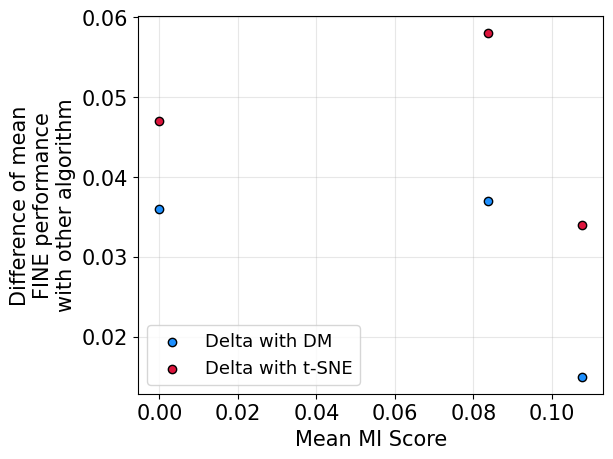

In [113]:
delta_dm   = []
std_dm     = []

delta_tsne = []
std_tsne   = []

mean_mi    = []

for i, key in enumerate(MI_data):
    
    if i in [0, 2, 4]:
        mean_mi.append(np.mean(MI_data[key]))
        delta_dm.append(fine_means[i]-dm_means[i])
        std_dm.append(np.std(np.array(fine_corrs[key])-np.array(dm_corrs[key])))
        delta_tsne.append(fine_means[i]-tsne_means[i])
        std_tsne.append(np.std(np.array(fine_corrs[key])-np.array(tsne_corrs[key])))
    
plt.scatter(mean_mi, delta_dm, color="dodgerblue", edgecolor="k", label="Delta with DM")
#plt.errorbar(mean_mi, delta_dm, yerr=std_dm, fmt="o", color="dodgerblue")

plt.scatter(mean_mi, delta_tsne, color="crimson", edgecolor="k", label="Delta with t-SNE")
#plt.errorbar(mean_mi, delta_tsne, yerr=std_tsne, fmt="o", color="crimson")


plt.xlabel("Mean MI Score")

plt.ylabel("Difference of mean\nFINE performance\nwith other algorithm")

plt.legend(loc="lower left")
plt.show()